# Bankruptcy Prediction Project
## 1. Data loading and initial exploration

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [55]:
df = pd.read_csv("./Bankruptcy_data_Final.csv", delimiter=';')

In [56]:
print(f"number of row: {df.shape[0]}")
print(f"number of columns: {df.shape[1]}")

number of row: 92872
number of columns: 15


In [57]:
df.head(10)

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1979,"0,980","1,580","0,360","0,180","0,130","1,330","1,770","0,070","0,150","2,220",NaN,NaN,NaN,0
1,1980,"0,980","1,410","0,360","0,190","0,120","1,310","1,590","0,070","0,130","2,410","0,126","0,014","0,040",0
2,1981,"0,870","0,310","0,320","0,130","0,080","1,030","1,550","0,050","0,040","2,560","0,368","0,328","0,567",0
3,1982,"1,130","0,710","0,280","0,140","0,080","0,800","1,390","0,060","0,050","5,280","-0,021","-0,119","-0,096",0
4,1983,"1,260","0,750","0,410","0,130","0,080","0,200","1,300","0,060","0,040","8,680","0,233","0,147","0,053",0
5,1984,"1,170","1,500","0,370","0,160","0,110","0,340","1,410","0,080","0,080","7,820","0,132","0,232","0,077",0
6,1985,"1,600","1,260","0,360","0,160","0,110","0,600","1,250","0,090","0,050","20,510","0,276","0,133","0,189",0
7,1986,"1,790","1,460","0,370","0,180","0,120","0,360","1,270","0,100","0,050","25,100","0,186","0,202","0,017",0
8,1987,"1,870","1,340","0,370","0,210","0,120","0,480","1,220","0,100","0,050","42,050","0,212","0,166","0,099",0
9,1988,"1,920","1,550","0,360","0,220","0,130","0,560","1,140","0,110","0,050","46,680","0,251","0,169","0,276",0


In [58]:
df.describe()

,Data Year - Fiscal,BK
count,92872.000000,92872.000000
mean,2004.105888,0.006008
std,9.875926,0.077280
min,1979.000000,0.000000
25%,1998.000000,0.000000
50%,2006.000000,0.000000
75%,2012.000000,0.000000
max,2017.000000,1.000000


In [59]:
missing_values = df.isnull().sum().sort_values(ascending=False)

print("number of missing values per column")
missing_values

number of missing values per column


Employee Growth       7010
Assets Growth         6701
Sales Growth          6701
Operational Margin    5557
Tobin's Q              252
Profitability          247
Liquidity              247
Asset Turnover         247
Productivity           247
Market Book Ratio       57
Leverage Ratio          26
Return on Equity         8
EPS                      5
Data Year - Fiscal       0
BK                       0
dtype: int64

In [60]:
missing_percentage = (missing_values / len(df)) * 100
print("percentage of missing values per column")
print(missing_percentage.round(2))

percentage of missing values per column
Employee Growth       7.55
Assets Growth         7.22
Sales Growth          7.22
Operational Margin    5.98
Tobin's Q             0.27
Profitability         0.27
Liquidity             0.27
Asset Turnover        0.27
Productivity          0.27
Market Book Ratio     0.06
Leverage Ratio        0.03
Return on Equity      0.01
EPS                   0.01
Data Year - Fiscal    0.00
BK                    0.00
dtype: float64


In [61]:
print("BK distribution - counts")
df["BK"].value_counts()

BK distribution - counts


BK
0    92314
1      558
Name: count, dtype: int64

In [62]:
print("BK distribution - percentages")
(df["BK"].value_counts(normalize=True) * 100).round(4)

BK distribution - percentages


BK
0    99.3992
1     0.6008
Name: proportion, dtype: float64

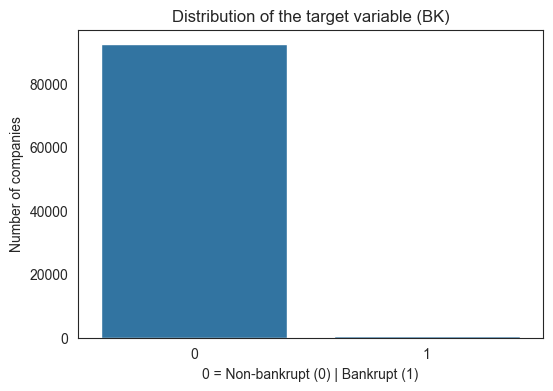

In [63]:
plt.figure(figsize=(6, 4))
sns.countplot(x="BK", data=df)
plt.title("Distribution of the target variable (BK)")
plt.xlabel("0 = Non-bankrupt (0) | Bankrupt (1)")
plt.ylabel("Number of companies")
plt.show()

In [64]:
print("Data types before conversion:")
df.dtypes

Data types before conversion:


Data Year - Fiscal     int64
Tobin's Q             object
EPS                   object
Liquidity             object
Profitability         object
Productivity          object
Leverage Ratio        object
Asset Turnover        object
Operational Margin    object
Return on Equity      object
Market Book Ratio     object
Assets Growth         object
Sales Growth          object
Employee Growth       object
BK                     int64
dtype: object

# 2. Data Preprocessing

### data type

In [65]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", ".", regex=False)

        try:
            df[col] = df[col].astype(float)
        except ValueError:
            print(f"Column '{col}' could not be converted to float and was kept as object.")

In [66]:
df.dtypes

Data Year - Fiscal      int64
Tobin's Q             float64
EPS                   float64
Liquidity             float64
Profitability         float64
Productivity          float64
Leverage Ratio        float64
Asset Turnover        float64
Operational Margin    float64
Return on Equity      float64
Market Book Ratio     float64
Assets Growth         float64
Sales Growth          float64
Employee Growth       float64
BK                      int64
dtype: object

### Duplicates

In [67]:
df.duplicated().sum()

np.int64(35)

In [68]:
df = df.drop_duplicates()

In [69]:
df.duplicated().sum()

np.int64(0)

In [70]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = outliers

print("number of detected outliers per numerical variable")
outlier_summary

number of detected outliers per numerical variable


{'Data Year - Fiscal': np.int64(0),
 "Tobin's Q": np.int64(10652),
 'EPS': np.int64(8384),
 'Liquidity': np.int64(4467),
 'Profitability': np.int64(14150),
 'Productivity': np.int64(13228),
 'Leverage Ratio': np.int64(10341),
 'Asset Turnover': np.int64(3706),
 'Operational Margin': np.int64(15573),
 'Return on Equity': np.int64(13061),
 'Market Book Ratio': np.int64(15997),
 'Assets Growth': np.int64(11973),
 'Sales Growth': np.int64(12418),
 'Employee Growth': np.int64(12677),
 'BK': np.int64(558)}

### missing values

In [71]:
df = df.fillna(df.median(numeric_only=True))

In [72]:
print("remaining missing values after imputation")
df.isnull().sum().sort_values(ascending=False).head(10)

remaining missing values after imputation


Data Year - Fiscal    0
Tobin's Q             0
EPS                   0
Liquidity             0
Profitability         0
Productivity          0
Leverage Ratio        0
Asset Turnover        0
Operational Margin    0
Return on Equity      0
dtype: int64

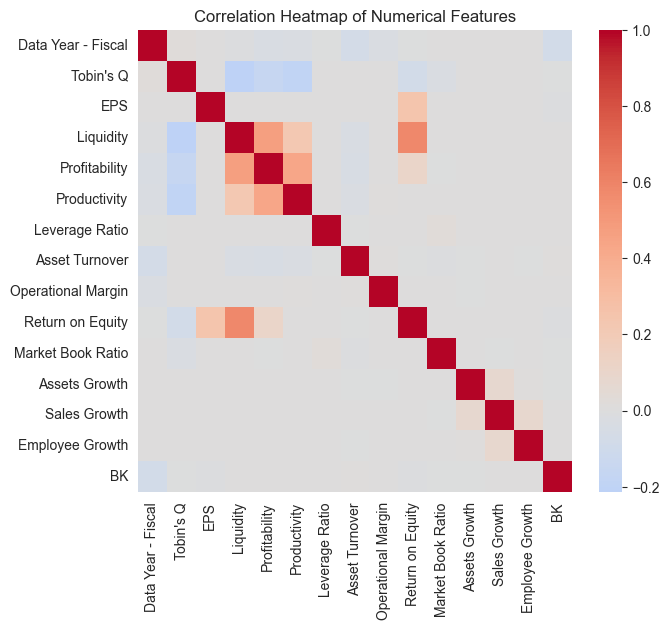

In [84]:
plt.figure(figsize=(7, 6))
corr_matrix = df.corr(method="pearson")
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numerical Features")
sns.set_style("white")
plt.show()

### distribution of Numerical Variables

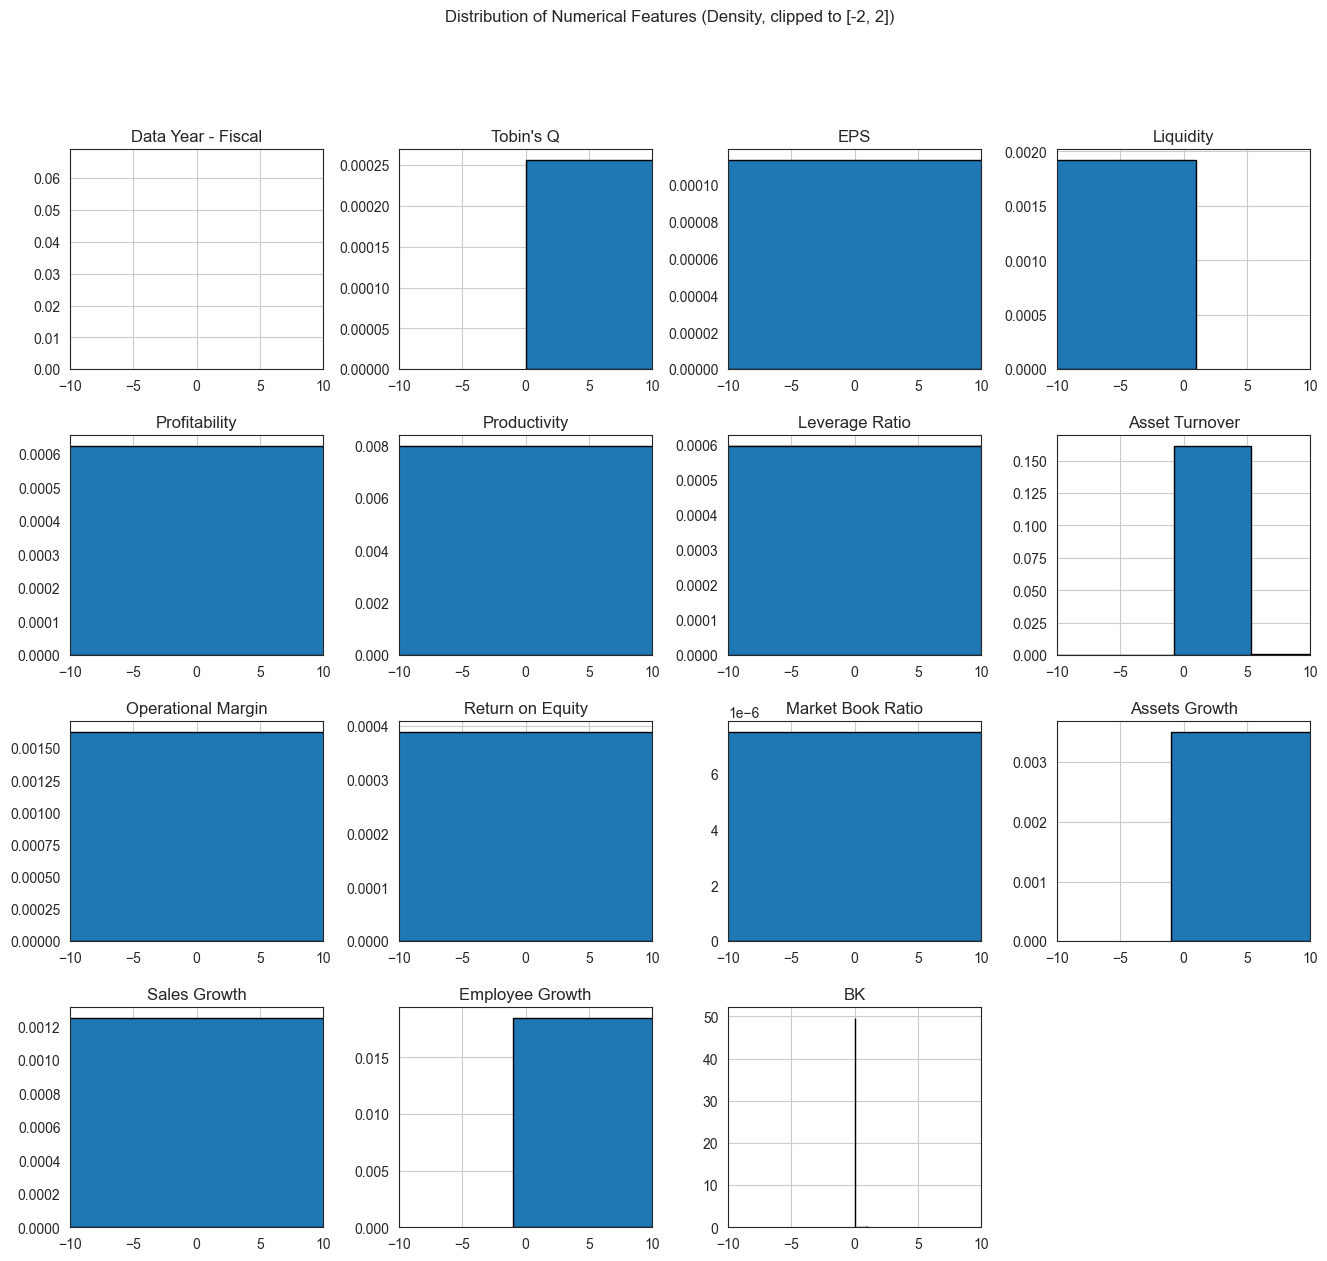

In [74]:
axes = df[numeric_cols].hist(
    figsize=(16, 14),
    bins=50,
    density=True,
    edgecolor="black"
)

for ax in axes.flatten():
    ax.set_xlim(-10, 10)

plt.suptitle("Distribution of Numerical Features (Density, clipped to [-2, 2])")
plt.show()

### box plots to visualise outliers

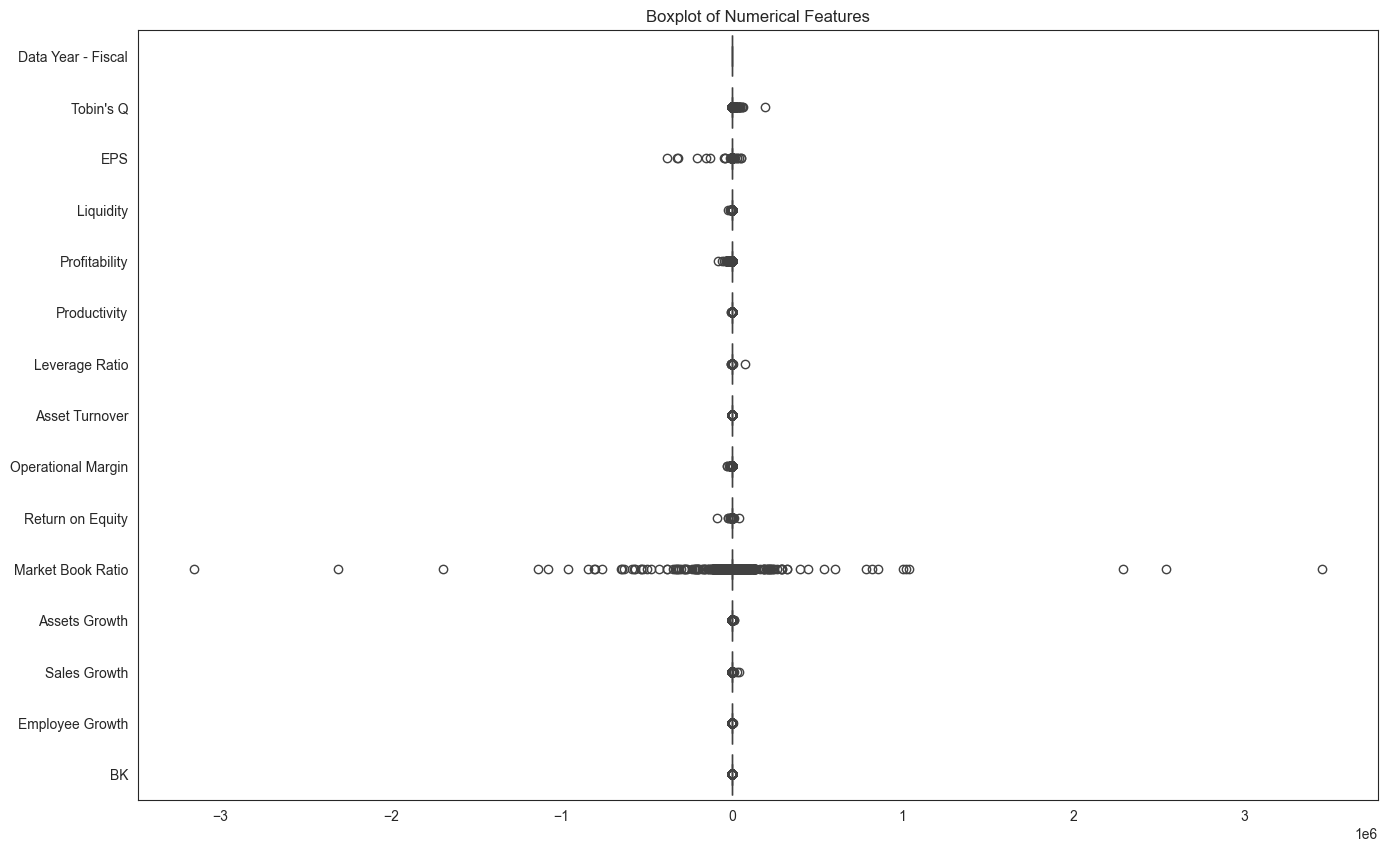

In [75]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df[numeric_cols], orient="h")
plt.title("Boxplot of Numerical Features")
plt.show()

### relationship Between Features and BK

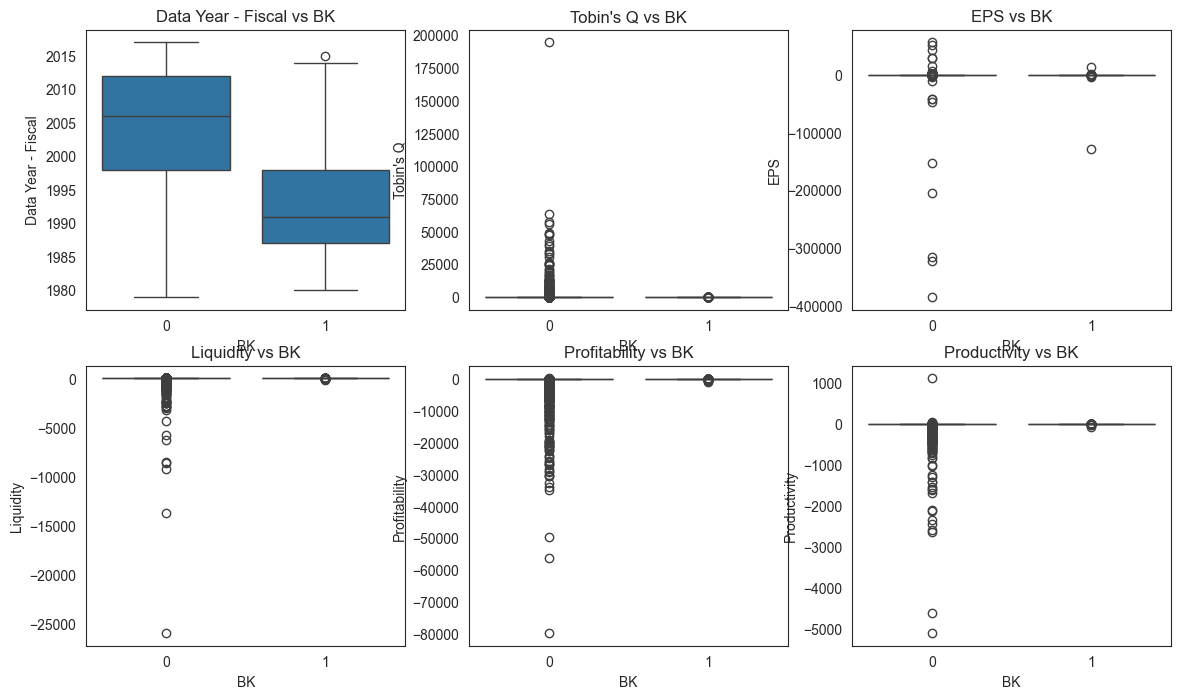

In [ ]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df["BK"], y=df[col])
    plt.title(f"{col} vs BK")
    
plt.tight_layout()
plt.show()

# 4. Train & Test Split, Scaling and Class Imbalance Handling

In [77]:
X = df.drop(columns=["BK"])
y = df["BK"]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y
)

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


In [80]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("before SMOTE :", y_train.value_counts())
print("after SMOTE :", y_train_res.value_counts())

before SMOTE : BK
0    73823
1      446
Name: count, dtype: int64
after SMOTE : BK
0    73823
1    73823
Name: count, dtype: int64


# 5. model training

### regression logistic

In [ ]:
log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    random_state=42
)
log_reg.fit(X_train_res, y_train_res)

In [83]:
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_prob_lr)

In [ ]:
confusion_matrix(y_test, y_pred_lr)

### Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train_res, y_train_res)


In [ ]:
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred_rf))

In [ ]:
roc_auc_score(y_test, y_prob_rf)

### SVM

In [ ]:

from sklearn.svm import SVC

svm_model = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    C=1,
    gamma="scale",
    random_state=42
)
svm_model.fit(X_train_res, y_train_res)


In [ ]:
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
roc_auc_score(y_test, y_prob_svm)

In [ ]:
confusion_matrix(y_test, y_pred_svm)

# 6. Model Evaluation, ROC Curves & Hyperparameter Tuning

In [ ]:
plt.figure(figsize=(10, 8))

models = {
    "Logistic Regression": (y_test, y_prob_lr),
    "Random Forest": (y_test, y_prob_rf),
    "SVM": (y_test, y_prob_svm)
}

for name, (yt, yp) in models.items():
    RocCurveDisplay.from_predictions(yt, yp, name=name)

plt.plot([0, 1], [0, 1], "k--")
plt.show()

### hyperparameter Tuning

In [ ]:
N_ITER = 5  # nombre de param test
N_CV = 3  # nombre de folds
N_JOB = 4  # nombre de cœurs que le pc va utiliser

In [ ]:
rf_params = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        class_weight="balanced",
        random_state=42
    ),
    param_distributions=rf_params,
    n_iter=N_ITER,
    cv=N_CV,
    scoring="roc_auc",
    random_state=42,
    n_jobs=N_JOB
)

rf_random.fit(X_train_res, y_train_res)
rf_best_params = rf_random.best_params_

In [ ]:
print("best parameters for Random Forest = ", rf_best_params)

### hyperparameter Tuning – SVM

In [ ]:
svm_params = {
    "C": [0.1, 1, 10, 50],
    "gamma": ["scale", 0.1, 0.01, 0.001],
    "kernel": ["rbf"]
}

In [ ]:
svm_random = RandomizedSearchCV(
    estimator=SVC(
        class_weight="balanced",
        probability=True,
        random_state=42
    ),
    param_distributions=svm_params,
    n_iter=3,
    cv=2,
    scoring="roc_auc",
    random_state=42,
    n_jobs=N_JOB
)

svm_random.fit(X_train_res, y_train_res)

svm_best_params = svm_random.best_params_

In [ ]:
print("best parameters for SVM = ", svm_best_params)